In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sequentia.preprocessing import Preprocess, downsample, normalize, fft

# Preprocessing

This tutorial notebook describes the preprocessing methods offered by Sequentia.

---

- [Preprocessing methods](#Preprocessing-methods)
  - [Downsampling (`downsample`)](#Downsampling-%28downsample%29)
    - [Averaging](#Averaging)
    - [Decimation](#Decimation)
  - [Normalizing (`normalize`)](#Normalization-%28normalize%29)
  - [Discrete Fourier Transform (`fft`)](#Discrete-Fourier-Transform-%28fft%29)
- [Accepted input formats](#Accepted-input-formats)
- [Combining preprocessing methods (`Preprocess`)](#Combining-preprocessing-methods-%28Preprocess%29)

## Preprocessing methods

Before we can look at the different preprocessing methods, we have to create a multivariate observation sequence, `F`, that we can use:

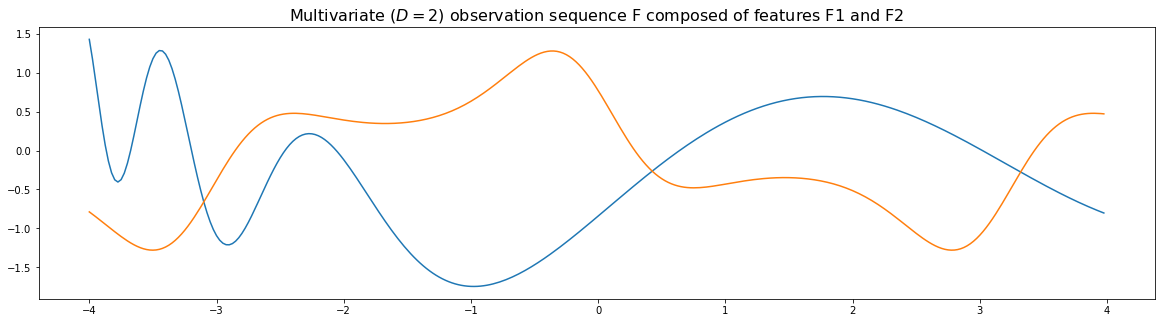

In [2]:
# Specify an input domain for the functions
xs = np.arange(-4., 4., 0.025)

# Create two lambdas that define the features of the observation sequence
f1 = lambda x: (np.sin(x) - np.sin(np.exp(-0.7 * x))).reshape(-1, 1)
f2 = lambda x: (np.exp(np.cos(2*x)) * np.cos(x - 5)).reshape(-1, 1)
# Auxilliary function for downsampling the domain (for plotting)
d = lambda x, n: downsample(x.reshape(-1, 1), n=n, method='decimate')

# Compute function values evaluated on the provided domain (xs)
F1, F2 = f1(xs), f2(xs)
# Combine F1 and F2 to form the features for the multivariate sequence F
F = np.hstack((F1, F2))

plt.figure(figsize=(20, 5))
plt.title('Multivariate ($D=2$) observation sequence F composed of features F1 and F2', fontsize=16)
plt.plot(xs, F)
plt.show()

### Downsampling (`downsample`)

_Reduces the number of frames in an observation sequence according to a specified downsample factor and one of two methods: **averaging** and **decimation**._

---

As an example, using a downsample factor of $n=5$ (and the decimation method – which is the default), we can significantly reduce the number of frames in the observation sequence:

In [3]:
print('Original shape: {}'.format(F.shape))
print('Downsampled shape (n=5): {}'.format(downsample(F, n=5).shape))

Original shape: (320, 2)
Downsampled shape (n=5): (64, 2)


#### Averaging

_With a downsample factor of $n$, averaging replaces every group of $n$ consequent observations with a new observation given by mean of those observations – reducing number of frames by $\frac{1}{n}$._

$$\texttt{downsample(sequence, n, method='average')}$$

---

The following plots allow us to see the effects of different downsample factors on the `average` downsampling method:

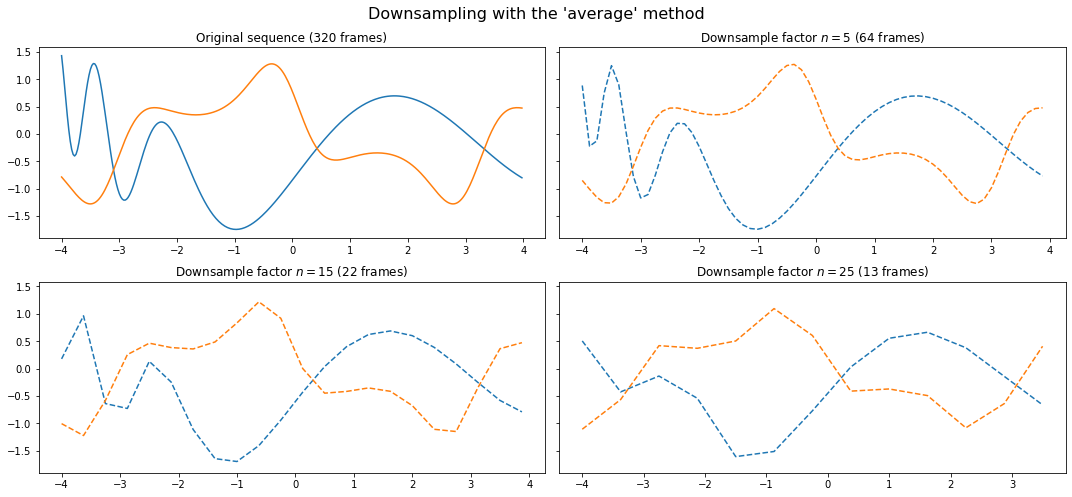

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True) 
fig.suptitle("Downsampling with the 'average' method", fontsize=16)

axs[0, 0].set_title('Original sequence ({} frames)'.format(len(F)))
axs[0, 0].plot(xs, F)

down = downsample(F, n=5, method='average')
axs[0, 1].set_title('Downsample factor $n=5$ ({} frames)'.format(len(down)))
axs[0, 1].plot(d(xs, n=5), down, '--')

down = downsample(F, n=15, method='average')
axs[1, 0].set_title('Downsample factor $n=15$ ({} frames)'.format(len(down)))
axs[1, 0].plot(d(xs, n=15), down, '--')

down = downsample(F, n=25, method='average')
axs[1, 1].set_title('Downsample factor $n=25$ ({} frames)'.format(len(down)))
axs[1, 1].plot(d(xs, n=25), down, '--')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Observe that even with just 64 frames, we can still capture most of the important information about the observation sequence – while making the sequence **five times smaller**!

This is often the case with observation sequences that are recorded using very high sample rates.

#### Decimation

_With a downsample factor $n$, decimation keeps every $n^\text{th}$ observation and removes (decimates) the subsequent $n-1$ observations._

$$\texttt{downsample(sequence, n, method='decimate')}$$

---

Once again, we can visualize the effects of the downsample factor by plotting the downsampled sequences.

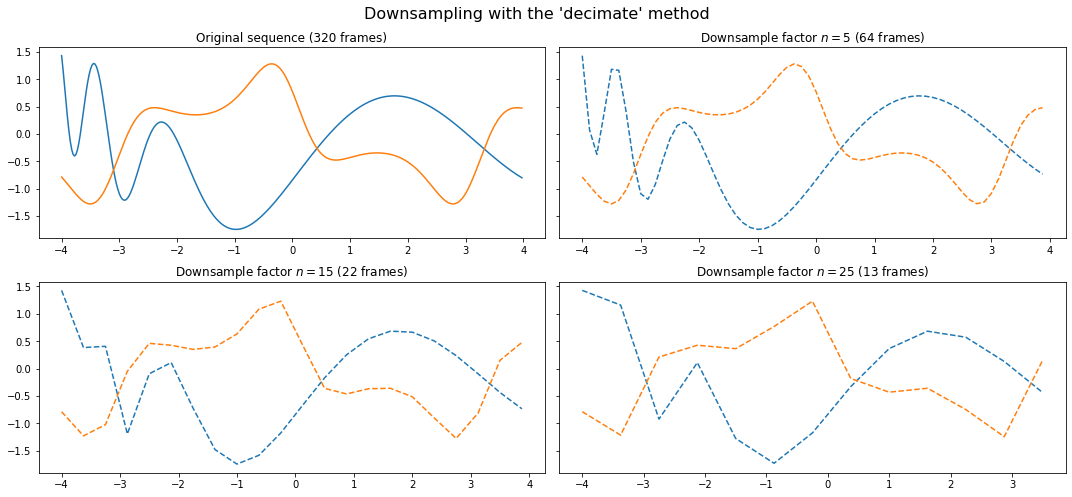

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True) 
fig.suptitle("Downsampling with the 'decimate' method", fontsize=16)

axs[0, 0].set_title('Original sequence ({} frames)'.format(len(F)))
axs[0, 0].plot(xs, F)

down = downsample(F, n=5, method='decimate')
axs[0, 1].set_title('Downsample factor $n=5$ ({} frames)'.format(len(down)))
axs[0, 1].plot(d(xs, n=5), down, '--')

down = downsample(F, n=15, method='decimate')
axs[1, 0].set_title('Downsample factor $n=15$ ({} frames)'.format(len(down)))
axs[1, 0].plot(d(xs, n=15), down, '--')

down = downsample(F, n=25, method='decimate')
axs[1, 1].set_title('Downsample factor $n=25$ ({} frames)'.format(len(down)))
axs[1, 1].plot(d(xs, n=25), down, '--')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

From these plots, the differences between downsampling through decimation and averaging aren't immediately obvious.

---

Lets look at a comparison of the two methods using a downsample factor of $n=15$:

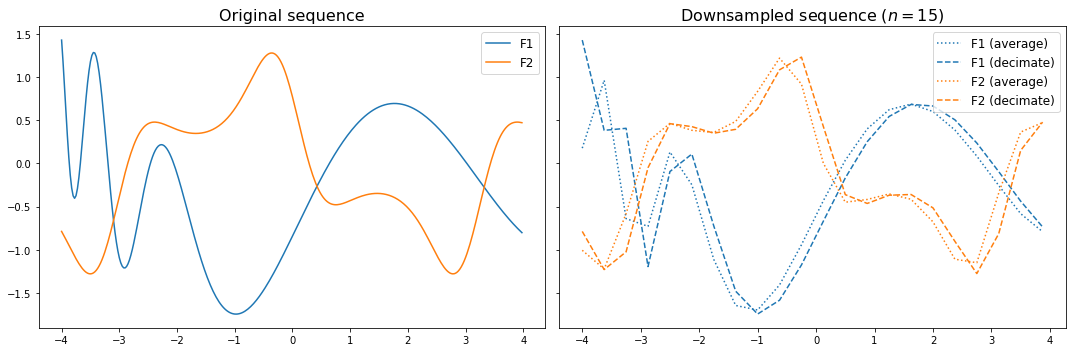

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
axs[0].set_title('Original sequence', fontsize=16)
axs[0].plot(xs, F1, label='F1')
axs[0].plot(xs, F2, label='F2')
axs[0].legend(fontsize=12)

axs[1].set_title('Downsampled sequence ($n=15$)', fontsize=16)
axs[1].plot(d(xs, n=15), downsample(F1, n=15, method='average'), 'C0:', label='F1 (average)')
axs[1].plot(d(xs, n=15), downsample(F1, n=15, method='decimate'), 'C0--', label='F1 (decimate)')
axs[1].plot(d(xs, n=15), downsample(F2, n=15, method='average'), 'C1:', label='F2 (average)')
axs[1].plot(d(xs, n=15), downsample(F2, n=15, method='decimate'), 'C1--', label='F2 (decimate)')
axs[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

Once again, it might not be straightforward to choose between the two methods. The best approach would probably be to choose the method that minimizes validation error.

### Normalization (`normalize`)

_Normalizes an observation sequence by independently centering each feature or dimension separately so that they each have zero mean. This is done by subtracting the mean observation of the sequence from each observation._

$$\texttt{normalize(sequence)}$$

---

As a simple check on `F`:

In [7]:
np.mean(normalize(F), axis=0)

array([-8.56953397e-17, -5.93275429e-17])

To see the effects of normalization, we can simply plot the normalized observation sequence:

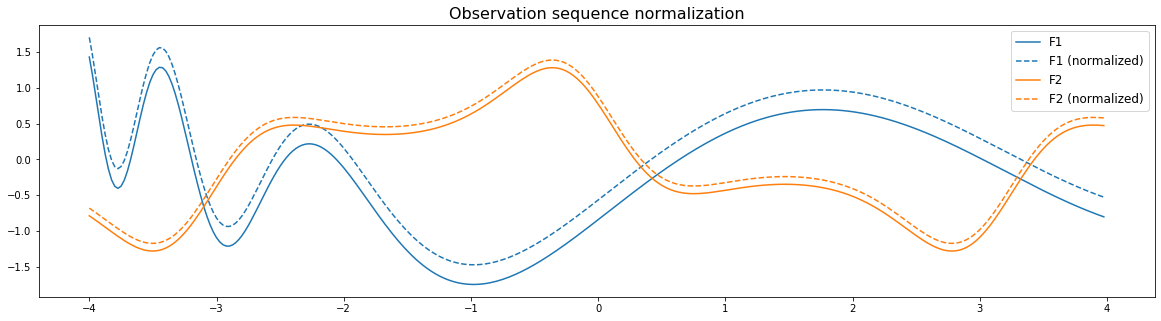

In [8]:
plt.figure(figsize=(20, 5))
plt.title('Observation sequence normalization', fontsize=16)
plt.plot(xs, F1, label='F1')
plt.plot(xs, normalize(F1), 'C0--', label='F1 (normalized)')
plt.plot(xs, F2, label='F2')
plt.plot(xs, normalize(F2), 'C1--', label='F2 (normalized)')
plt.legend(fontsize=12)
plt.show()

### Discrete Fourier Transform (`fft`)

_Converts the observation sequence into a real-valued, same-length sequence of equally-spaced samples of the discrete-time Fourier transform._

$$\texttt{fft(sequence)}$$

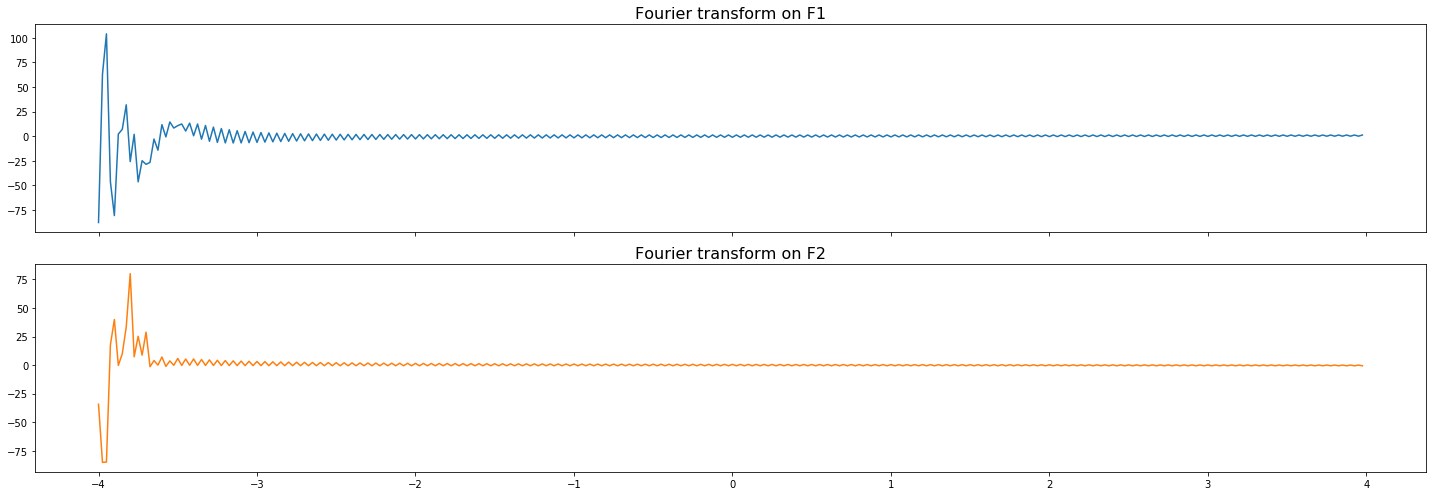

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(20, 7), sharex=True)
axs[0].plot(xs, fft(F1), 'C0')
axs[0].set_title('Fourier transform on F1', fontsize=16)
axs[1].plot(xs, fft(F2), 'C1')
axs[1].set_title('Fourier transform on F2', fontsize=16)
plt.tight_layout()
plt.show()

## Accepted input formats

Just as with the `fit()` and `predict()` functions on the Sequentia classifiers, each of the preprocessing functions accepts:

- `numpy.ndarray`: A single multivariate observation sequence
- `list(numpy.ndarray)`: Multiple multivariate observation sequences

**Note**: The observation sequences must strictly have a second dimension. If using one-dimensional observation sequences, these must be reshaped from `(T,)` to `(T, 1)`, where `T` is the number of frames.

---

Nothing changes about how you call the preprocessing functions:

In [10]:
# Single multivariate observation sequences
down = downsample(F, n=5, method='average')
down.shape

(64, 2)

In [11]:
# Multiple multivariate observation sequences
Fs = [F]*5
down = downsample(Fs, n=5, method='average')
[f.shape for f in down]

[(64, 2), (64, 2), (64, 2), (64, 2), (64, 2)]

## Combining preprocessing methods (`Preprocess`)

It is possible to combine preprocessing methods by simply making nested function calls, as shown below:

In [12]:
fft(downsample(normalize(F), n=5, method='average'));

This is fine if we are working with a single observation sequence. However, this can be slow when applied to multiple observation sequences. This is due to each preprocessing method call requiring a separate loop through the observation sequences.

---

The `Preprocess` class can be used to chain preprocessing method calls in a more efficient manner. To see the difference in terms of speed, lets duplicate the observation sequence `F` that we were using before:

In [13]:
Fs = [F]*1000000

Chaining preprocessing method calls:

In [14]:
%%time
Fs_t = fft(downsample(normalize(Fs), n=5, method='average'))

CPU times: user 1min 46s, sys: 38.6 s, total: 2min 25s
Wall time: 5min 6s


Using the `Preprocess` class:

In [15]:
%%time
pre = Preprocess()
pre.normalize()
pre.downsample(n=5, method='average')
pre.fft()

Fs_t = pre.transform(Fs)

CPU times: user 1min 45s, sys: 36.7 s, total: 2min 22s
Wall time: 5min 10s


This isn't actually a speed-up yet, but the `Preprocess` class will support multi-processing some time in the near future!